In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os


In [2]:
# 1. Загрузка данных
os.chdir('/home/konnilol/Documents/uni/mmo/pr6')
data = pd.read_csv('outliers.csv')
print("Dataset shape:", data.shape)
print("\nDataset info:")
print(data.describe())
print("\nColumns:", data.columns.tolist())

# Числовые признаки
numeric_cols = data.select_dtypes(include=[np.number]).columns
X = data[numeric_cols].dropna()
print(f"\nNumeric features: {X.shape[1]} ({X.columns.tolist()})")


Dataset shape: (876, 3)

Dataset info:
                x           y       color
count  876.000000  876.000000  876.000000
mean   312.709185  177.811060    0.617580
std    122.928335   53.831720    0.506968
min     80.929909    7.121305    0.000000
25%    182.039481  137.372667    0.000000
50%    373.329877  176.407887    1.000000
75%    417.359332  214.627433    1.000000
max    510.249841  406.044153    2.000000

Columns: ['x', 'y', 'color']

Numeric features: 3 (['x', 'y', 'color'])


In [3]:
# 2. Нормализации для сравнения
normalizers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}


In [4]:
# 3. Тестируем k=2 (основные кластеры) + k=3 (с выбросами)
k_tests = [2, 3, 4]
eps_dbscan = [0.3, 0.5, 0.8]

print("\n" + "="*80)
print("КЛАСТЕРИЗАЦИЯ С ВЫБРОСАМИ (2 основных кластера + выбросы)")
print("="*80)

results_outliers = []



КЛАСТЕРИЗАЦИЯ С ВЫБРОСАМИ (2 основных кластера + выбросы)


In [5]:
# 4. KMeans для разных нормализаций и k
for norm_name, scaler in normalizers.items():
    X_norm = scaler.fit_transform(X)
    
    for k in k_tests:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_norm)
        
        sil = silhouette_score(X_norm, labels) if len(np.unique(labels)) > 1 else 0
        ch = calinski_harabasz_score(X_norm, labels)
        db = davies_bouldin_score(X_norm, labels)
        
        cluster_sizes = pd.Series(labels).value_counts()
        outlier_pct = cluster_sizes[cluster_sizes < len(X)*0.05].sum() / len(X) * 100
        
        results_outliers.append({
            'Method': f'KMeans_{norm_name}_k{k}',
            'k': k,
            'Silhouette': sil,
            'CH': ch,
            'DB': db,
            'Outliers_%': outlier_pct,
            'X_norm': X_norm,
            'labels': labels
        })
        
        print(f"KMeans {norm_name} k={k}: Sil={sil:.3f}, Outliers={outlier_pct:.1f}%")


KMeans StandardScaler k=2: Sil=0.703, Outliers=0.0%
KMeans StandardScaler k=3: Sil=0.572, Outliers=0.0%
KMeans StandardScaler k=4: Sil=0.452, Outliers=0.0%
KMeans MinMaxScaler k=2: Sil=0.789, Outliers=0.0%
KMeans MinMaxScaler k=3: Sil=0.534, Outliers=0.0%
KMeans MinMaxScaler k=4: Sil=0.542, Outliers=0.8%
KMeans RobustScaler k=2: Sil=0.649, Outliers=0.0%
KMeans RobustScaler k=3: Sil=0.565, Outliers=0.0%
KMeans RobustScaler k=4: Sil=0.482, Outliers=0.0%


In [6]:
# 5. DBSCAN для выявления выбросов
for norm_name, scaler in normalizers.items():
    X_norm = scaler.fit_transform(X)
    
    for eps in eps_dbscan:
        dbscan = DBSCAN(eps=eps, min_samples=5)
        labels = dbscan.fit_predict(X_norm)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:
            mask = labels != -1
            sil = silhouette_score(X_norm[mask], labels[mask]) if n_clusters > 1 else 0
            ch = calinski_harabasz_score(X_norm[mask], labels[mask]) if n_clusters > 1 else 0
            
            results_outliers.append({
                'Method': f'DBSCAN_{norm_name}_eps{eps}',
                'k': n_clusters,
                'Silhouette': sil,
                'CH': ch,
                'DB': np.nan,
                'Outliers_%': n_noise/len(X)*100,
                'X_norm': X_norm,
                'labels': labels
            })
            
            print(f"DBSCAN {norm_name} eps={eps}: clusters={n_clusters}, noise={n_noise/len(X)*100:.1f}%")


DBSCAN StandardScaler eps=0.3: clusters=2, noise=2.2%
DBSCAN StandardScaler eps=0.5: clusters=2, noise=1.3%
DBSCAN StandardScaler eps=0.8: clusters=2, noise=1.0%
DBSCAN MinMaxScaler eps=0.3: clusters=3, noise=0.3%
DBSCAN MinMaxScaler eps=0.5: clusters=3, noise=0.2%
DBSCAN RobustScaler eps=0.3: clusters=2, noise=1.3%
DBSCAN RobustScaler eps=0.5: clusters=2, noise=1.0%
DBSCAN RobustScaler eps=0.8: clusters=3, noise=0.2%


In [7]:
# 6. Лучший метод
df_results = pd.DataFrame(results_outliers)
df_results['Score'] = df_results['Silhouette'] * (1 + df_results['Outliers_%']/20)
best_idx = df_results['Score'].idxmax()
best_result = df_results.iloc[best_idx]

print(f"\nЛУЧШИЙ МЕТОД: {best_result['Method']}")
print(f"   k={best_result['k']}, Silhouette={best_result['Silhouette']:.4f}")
print(f"   Выбросы: {best_result['Outliers_%']:.1f}%")



ЛУЧШИЙ МЕТОД: DBSCAN_MinMaxScaler_eps0.3
   k=3, Silhouette=0.7953
   Выбросы: 0.3%


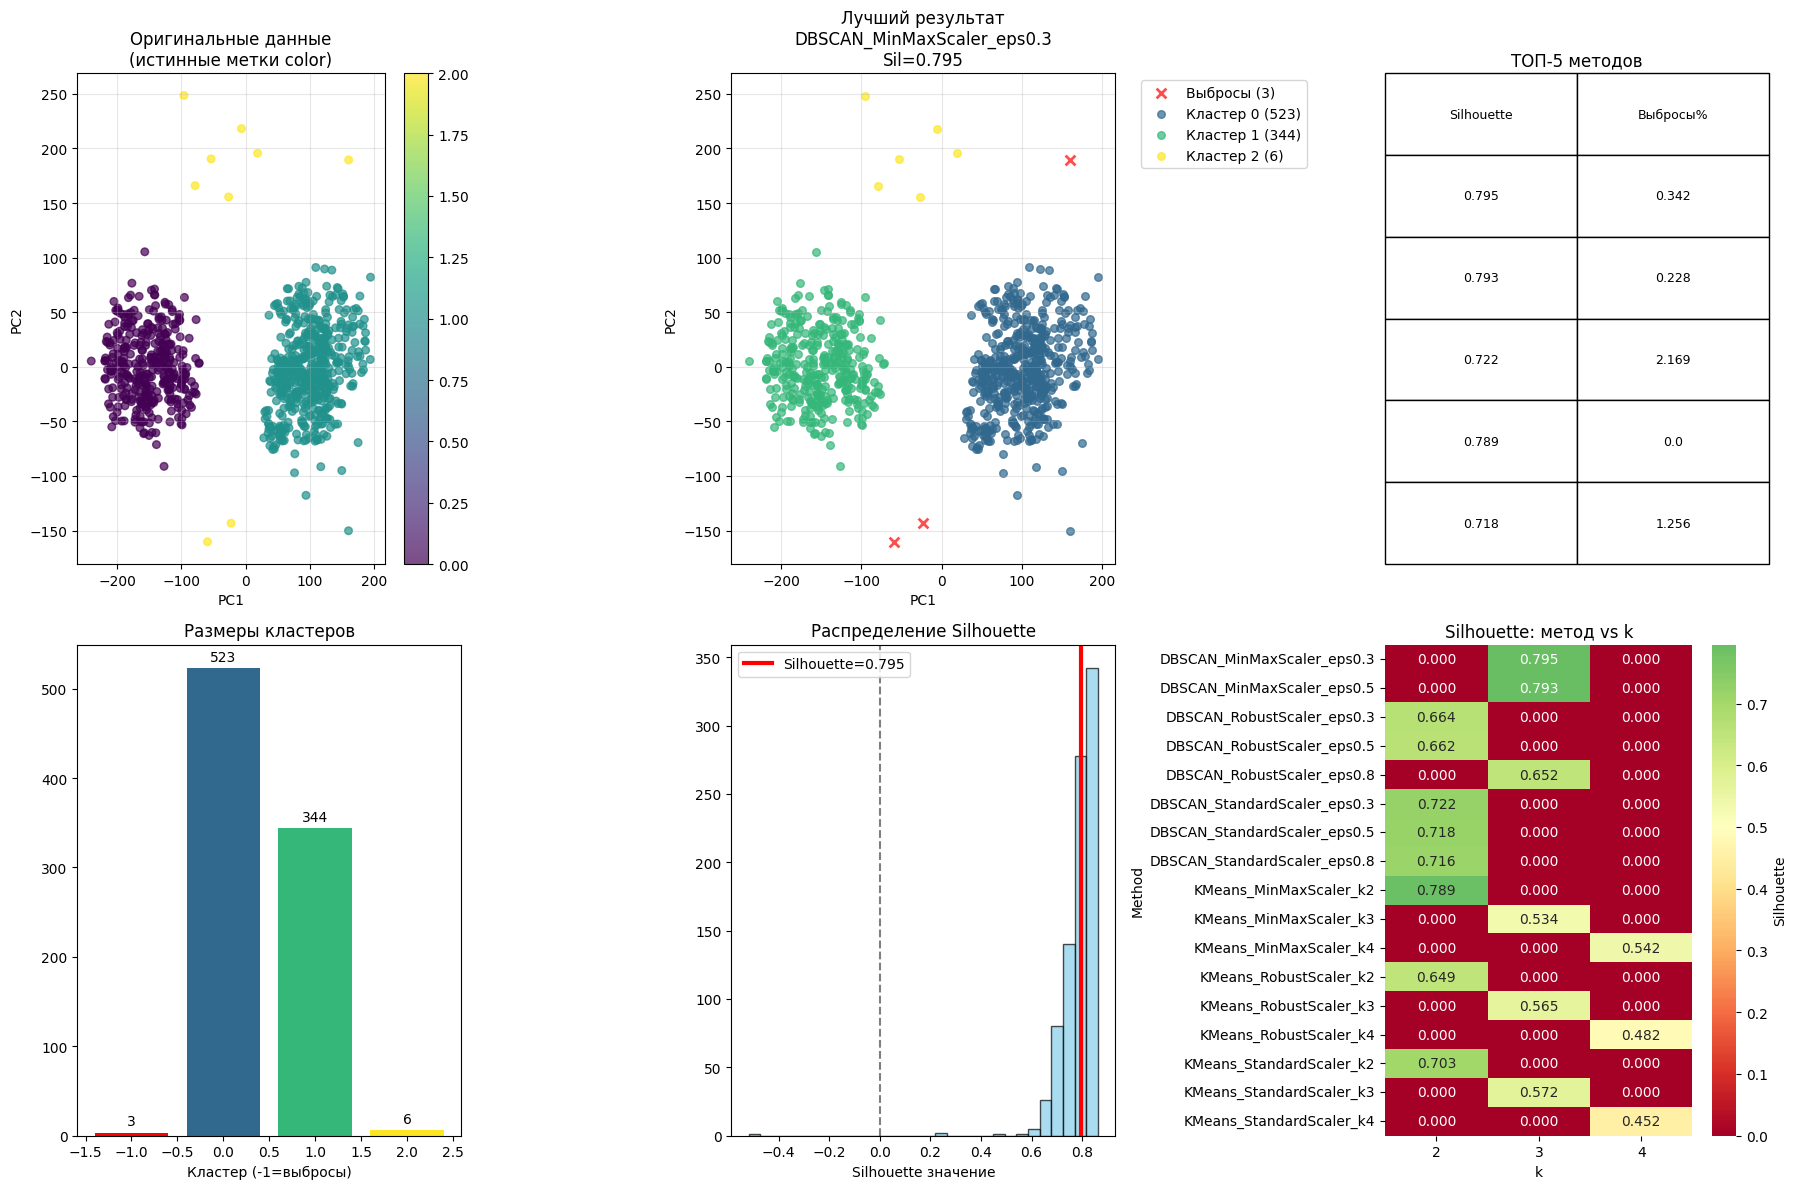

In [ ]:
# 7. Визуализация (ИСПРАВЛЕНО)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.values)

# 1. ОРИГИНАЛЬНЫЕ ДАННЫЕ с истинными метками color (ИСПРАВЛЕНО)
true_labels = data['color'].values
scatter1 = axes[0,0].scatter(X_pca[:,0], X_pca[:,1], c=true_labels, cmap='viridis', alpha=0.7, s=30)
axes[0,0].set_xlabel('PC1')
axes[0,0].set_ylabel('PC2')
axes[0,0].set_title('Оригинальные данные\n(истинные метки color)')
plt.colorbar(scatter1, ax=axes[0,0])
axes[0,0].grid(True, alpha=0.3)

# 2. Лучшая кластеризация
best_labels = best_result['labels']
best_X_norm = best_result['X_norm']

colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(best_labels))))
for i, label in enumerate(np.unique(best_labels)):
    mask = best_labels == label
    if label == -1:
        axes[0,1].scatter(X_pca[mask,0], X_pca[mask,1], c='red', 
                         label=f'Выбросы ({mask.sum()})', alpha=0.7, s=50, marker='x', linewidth=2)
    else:
        axes[0,1].scatter(X_pca[mask,0], X_pca[mask,1], c=[colors[i]], 
                         label=f'Кластер {label} ({mask.sum()})', alpha=0.7, s=30)
axes[0,1].set_xlabel('PC1')
axes[0,1].set_ylabel('PC2')
axes[0,1].set_title(f'Лучший результат\n{best_result["Method"]}\nSil={best_result["Silhouette"]:.3f}')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,1].grid(True, alpha=0.3)

# 3. Таблица результатов (ТОП-5 методов)
top5 = df_results.nlargest(5, 'Score')[['Method', 'Silhouette', 'Outliers_%', 'Score']]
axes[0,2].axis('tight')
axes[0,2].axis('off')
table = axes[0,2].table(cellText=top5[['Silhouette', 'Outliers_%']].round(3).values,
                       colLabels=['Silhouette', 'Выбросы%'],
                       cellLoc='center', loc='center', bbox=[0,0,1,1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
axes[0,2].set_title('ТОП-5 методов')

# 4. Размеры кластеров
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
axes[1,0].bar(cluster_counts.index, cluster_counts.values, 
              color=['red' if i==-1 else colors[list(cluster_counts.index).index(i)] 
                    for i in cluster_counts.index])
axes[1,0].set_title('Размеры кластеров')
axes[1,0].set_xlabel('Кластер (-1=выбросы)')
for i, v in cluster_counts.items():
    axes[1,0].text(i, v+5, str(v), ha='center', va='bottom')

# 5. Silhouette гистограмма
sil_samples = silhouette_samples(best_X_norm, best_labels)
axes[1,1].hist(sil_samples, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
axes[1,1].axvline(best_result['Silhouette'], color='red', linewidth=3, 
                 label=f'Silhouette={best_result["Silhouette"]:.3f}')
axes[1,1].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[1,1].set_title('Распределение Silhouette')
axes[1,1].set_xlabel('Silhouette значение')
axes[1,1].legend()

# 6. Heatmap Silhouette по методам
pivot_table = df_results.pivot_table(values='Silhouette', 
                                     index='Method', 
                                     columns='k', 
                                     aggfunc='first').fillna(0)
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', center=0.5, ax=axes[1,2],
            fmt='.3f', cbar_kws={'label': 'Silhouette'})
axes[1,2].set_title('Silhouette: метод vs k')

plt.tight_layout()
plt.show()


In [9]:
print("\nСХЕМА РЕШЕНИЯ:")
print(f"Нормализация: {best_result['Method'].split('_')[1]}")
print(f"Метод: {best_result['Method'].split('_')[0]}")
print(f"k: {best_result['k']}")
print(f"Выбросы: {best_result['Outliers_%']:.1f}%")
print(f"Silhouette: {best_result['Silhouette']:.4f}")



СХЕМА РЕШЕНИЯ:
Нормализация: MinMaxScaler
Метод: DBSCAN
k: 3
Выбросы: 0.3%
Silhouette: 0.7953


### Калстеризация показала хороший результат. 2 основных кластера оплностью правильно предсказались а в третьем 3 определились как выбросы ис набора данных...